<a href="https://colab.research.google.com/github/envirodatascience/final-project-urban-treeam/blob/main/Final_Project_URI_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project for ENV 617 2024

**Research Question:**

How do street trees vary across New Haven, particularly as a result of specific management/planting choices?

**Source Data**

To address this question we will use the data available from the Urban Resources Initiative (URI)

## A) Biodiversity of urban trees in New Haven

URI prioritizes the diversity of tree species, avoiding planting too many individual trees of a single species or even a single genus in a small, localized area. The impact of emerald ash borer on white ash can exemplify the reason for this strategic approach. The outbreak of a pest or disease can cause detrimental effects on tree canopies when too many individuals are susceptible to that pest or disease and are planted in one location.

Throughout the years, New Haven has experienced almost total canopy loss of affected species from different pests and diseases such as emerald ash borer, chestnut blight, and Dutch elm disease. URI aims to protect the trees by maintaining high levels of biodiversity, which will reduce and spread out the impact of future disturbances.

The biodiversity component of our project aims to understand the current levels of biodiversity and tree conditions in New Haven and to assess to what degree URI has successfully pursued biodiversity in plantings.




**Specific questions that we are adressing:**

* What neighborhood in New Haven is more biodiverse?

* What neighborhood has trees in better and worse conditions?

* Has the URI program increased tree biodiversity in New Haven ?

 ### Part 1: Set up



#### Import modules and read the data

The URI data is available on GitHub at the link below:
```
https://raw.githubusercontent.com/envirodatascience/final-project-urban-treeam/main/all_trees_58_1713995132.csv"
```

In [317]:
# Import modules

import pandas as pd
import numpy as np
from plotnine import *
import plotnine
import geopandas as gpd
import matplotlib.pyplot as plt


In [318]:
url= "https://raw.githubusercontent.com/envirodatascience/final-project-urban-treeam/main/all_trees_58_1713995132.csv"
df= pd.read_csv(url)

### Part 2: Explore and clean data


#### Structure of the data

We start exploring and looking to the structure of the data.

* Rename columns
* Check for duplicate values

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df.describe().T

In [ ]:
# Rename columns
new_column_names = {
    'Site ID': 'Site_ID',
    '(Common) Species': 'Common_Name',
    '(Botanical) Species': 'Latin_Name',
    'Utility Wire Conflict':'Wire',
    '(Botanical) Species (Genus)': 'Genus',
    'Valuation Total': 'Valuation_Total',
    'Last Editor': 'Last_Editor',
    'Grow Space': 'Grow_Space'
}

df = df.rename(columns=new_column_names)

df.head()


In [ ]:
# Check the distribution of DBH values
df.DBH.hist()

In [ ]:
df[df["DBH"]>100]

In [323]:
#Check for duplicates
df[df.duplicated()]

,Site_ID,Latitude,Longitude,Latin_Name,Common_Name,Condition,DBH,Wire,Grow_Space,Planting Organization,Neighborhood,Planted Date,Department,Genus,(Common) Species (Genus),Last_Editor,Valuation_Total,Valuation Type,Sites


In [324]:
df[df.duplicated(subset=["Site_ID"])]

,Site_ID,Latitude,Longitude,Latin_Name,Common_Name,Condition,DBH,Wire,Grow_Space,Planting Organization,Neighborhood,Planted Date,Department,Genus,(Common) Species (Genus),Last_Editor,Valuation_Total,Valuation Type,Sites


#### Explore missing values

In [325]:
# Check missing values in Condition, DBH, Neighborhood
df.Condition.unique()

array(['Stump', nan, 'Good', 'Fair', 'Poor', 'Very Poor', 'Excellent',
       'Standing Dead'], dtype=object)

In [326]:
df[df.DBH.isna()]

,Site_ID,Latitude,Longitude,Latin_Name,Common_Name,Condition,DBH,Wire,Grow_Space,Planting Organization,Neighborhood,Planted Date,Department,Genus,(Common) Species (Genus),Last_Editor,Valuation_Total,Valuation Type,Sites


In [327]:
df[df.Neighborhood.isna()]

,Site_ID,Latitude,Longitude,Latin_Name,Common_Name,Condition,DBH,Wire,Grow_Space,Planting Organization,Neighborhood,Planted Date,Department,Genus,(Common) Species (Genus),Last_Editor,Valuation_Total,Valuation Type,Sites
10057,10542,41.335468,-72.839195,Acer rubrum,"Maple, Red",NaN,34.0,No,Sidewalk Tree Pit,NaN,NaN,NaN,Street Tree,Acer,Maple,Alex Foreman (DRG),415.0,Estimate,10542
11481,12036,41.253235,-72.995533,Tilia americana,"Linden, American (aka Basswood)",NaN,0.0,No,Sidewalk Tree Pit,URI,NaN,2015-10-07,Street Tree,Tilia,Linden,Alex Foreman (DRG),415.0,Estimate,12036


#### Drop unnecessary values

Based on prior knowlege of the dataset, there are some specific things we want to filter out.

* Get rid of "Vacant Site"
* Drop values with DBH less than cero
* Drop NaN

Before dropping values we will create a new database df_clean.




There are some vacant sites, which are labeled as such in their latin and common names. These don't represent trees anymore, so we don't want to include them.

In [328]:
#Get rid of "Vacant Site"

#Check the number of "Vacant Site" values
(df['Latin_Name'] == 'Vacant Site').sum()


102

In [329]:
#Create new data frame with clean data
#Drop "Vacant Site" values
df_clean = df[df['Latin_Name'] != 'Vacant Site']

#Check the results
print((df_clean['Latin_Name'] == 'Vacant Site').sum())
print("trees remaining: ", len(df_clean))

0
trees remaining:  30476


DBH (Diameter at Breast Height) column represent the size of each tree, we don't values that are less than cero as they might represent an error.

In [330]:
# Drop values that have DBH =<0

# Number of values that have DBH <0
len(df_clean[df_clean.DBH<=0])

387

In [331]:
df_clean = df_clean[df_clean["DBH"]>0]
print("trees remaining: ", len(df_clean))

trees remaining:  30089


We visualize that there is a DBH value higher than 100. This might be an error as there is no tree in New Haven with such dimensions. We will drop this row too.

In [ ]:
df_clean= df_clean[~(df_clean["DBH"]>100)]

The data has missing values, so we will eliminate the rows with NaN. In addition we will drop values that have are _unknown, _other and stump as they do not respresent a specie or a living tree.


In [332]:
#Drop Nan from Condition
df_clean = df_clean[df_clean.Condition.notna()]

In [333]:
# Check results
df_clean[df_clean.DBH.isna()]
print("trees remaining: ", len(df_clean))

trees remaining:  16554


In [ ]:
df_clean.Latin_Name.unique()

In [335]:
#Drop values from Columns "Latin_Name" and "Condition" that we do not need
df_clean = df_clean[df_clean['Latin_Name'] != '__UNKNOWN']
print("trees remaining: ", len(df_clean))

trees remaining:  16506


In [336]:
df_clean = df_clean[df_clean['Latin_Name'] != '__OTHER']
print("trees remaining: ", len(df_clean))

trees remaining:  16496


In [337]:
df_clean = df_clean[df_clean['Latin_Name'] != 'Stump']
print("trees remaining: ", len(df_clean))

trees remaining:  15516


In [338]:
df_clean = df_clean[df_clean['Condition'] != 'Stump']
print("trees remaining: ", len(df_clean))

trees remaining:  15384


Until this part, **df_clean** it is our clean data set"

In [362]:
#print("Until this part, df_clean it is our clean data set")
print("df_clean:", df_clean.shape)

df_clean: (15383, 19)


### Part 3: Summarize data

We will create a new data frame that has only the trees of streets. We want to focus on the biodiversity of trees in strees.

Table of how many trees are per neighborhood and per species

In [86]:
# Number of trees in each Neighborhood (total)
df_neig = df_clean.groupby('Neighborhood').agg(Trees=('Latin_Name','count')).reset_index()
df_neig

,Neighborhood,Trees
0,Amity,148
1,Annex,798
2,Beaver Hills,202
3,Cedar Hill,155
4,Dixwell,1489
5,Downtown,204
6,Dwight,893
7,East Rock,375
8,East Shore,242
9,Edgewood,142


In [87]:
# Number of species in each Neighborhood (total)
df_species = df_clean.groupby('Neighborhood').agg(Tree_Species =('Latin_Name','nunique')).reset_index()
df_species

,Neighborhood,Tree_Species
0,Amity,46
1,Annex,77
2,Beaver Hills,56
3,Cedar Hill,38
4,Dixwell,88
5,Downtown,36
6,Dwight,69
7,East Rock,64
8,East Shore,57
9,Edgewood,61


In [88]:
# Condition of trees in New Haven
df_a = df_clean.groupby(['Neighborhood','Condition']).agg(Trees_Condition = ('Latin_Name','count')).reset_index()
df_cond=df_a.pivot(index='Neighborhood', columns='Condition', values='Trees_Condition').reset_index()

In [89]:
# Replace NaN for cero in Condition data frame
df_cond.fillna(0, inplace=True)
df_cond

Condition,Neighborhood,Excellent,Fair,Good,Poor,Standing Dead,Very Poor
0,Amity,64.0,22.0,49.0,6.0,2.0,5.0
1,Annex,139.0,281.0,235.0,111.0,4.0,28.0
2,Beaver Hills,72.0,24.0,92.0,6.0,4.0,4.0
3,Cedar Hill,20.0,42.0,69.0,16.0,7.0,1.0
4,Dixwell,365.0,360.0,520.0,184.0,14.0,46.0
5,Downtown,43.0,40.0,58.0,26.0,23.0,14.0
6,Dwight,95.0,325.0,275.0,148.0,5.0,45.0
7,East Rock,111.0,32.0,187.0,22.0,8.0,15.0
8,East Shore,108.0,32.0,97.0,1.0,2.0,2.0
9,Edgewood,65.0,18.0,53.0,3.0,0.0,3.0


In [182]:
# Percentage of trees in each condition
# Calculate the total number of trees in each neighborhood
total_trees_neighborhood = df_clean.groupby('Neighborhood')['Latin_Name'].count()

# Calculate the percentage of trees in each condition for each neighborhood
df_a = df_clean.groupby(['Neighborhood', 'Condition'])['Latin_Name'].count() / total_trees_neighborhood * 100
df_a = df_a.reset_index(name='Trees_Condition_Percentage')

# Pivot the DataFrame to have neighborhoods as rows and conditions as columns
df_condition_percentage = df_a.pivot(index='Neighborhood', columns='Condition', values='Trees_Condition_Percentage').reset_index()
df_condition_percentage

Condition,Neighborhood,Excellent,Fair,Good,Poor,Standing Dead,Very Poor
0,Amity,43.243243,14.864865,33.108108,4.054054,1.351351,3.378378
1,Annex,17.418546,35.213033,29.448622,13.909774,0.501253,3.508772
2,Beaver Hills,35.643564,11.881188,45.544554,2.970297,1.980198,1.980198
3,Cedar Hill,12.903226,27.096774,44.516129,10.322581,4.516129,0.645161
4,Dixwell,24.513096,24.177300,34.922767,12.357287,0.940228,3.089322
5,Downtown,21.078431,19.607843,28.431373,12.745098,11.274510,6.862745
6,Dwight,10.638298,36.394177,30.795073,16.573348,0.559910,5.039194
7,East Rock,29.600000,8.533333,49.866667,5.866667,2.133333,4.000000
8,East Shore,44.628099,13.223140,40.082645,0.413223,0.826446,0.826446
9,Edgewood,45.774648,12.676056,37.323944,2.112676,NaN,2.112676


In [90]:
# Summary table trees and species per neighborhood
df_tab= df_neig.merge(df_species, how='outer', on='Neighborhood', indicator = True)
df_tab

,Neighborhood,Trees,Tree_Species,_merge
0,Amity,148,46,both
1,Annex,798,77,both
2,Beaver Hills,202,56,both
3,Cedar Hill,155,38,both
4,Dixwell,1489,88,both
5,Downtown,204,36,both
6,Dwight,893,69,both
7,East Rock,375,64,both
8,East Shore,242,57,both
9,Edgewood,142,61,both


In [91]:
# Summary table of trees and species + Condition
df_neitree= df_tab.merge(df_cond, how='inner', on='Neighborhood')
df_neitree

,Neighborhood,Trees,Tree_Species,_merge,Excellent,Fair,Good,Poor,Standing Dead,Very Poor
0,Amity,148,46,both,64.0,22.0,49.0,6.0,2.0,5.0
1,Annex,798,77,both,139.0,281.0,235.0,111.0,4.0,28.0
2,Beaver Hills,202,56,both,72.0,24.0,92.0,6.0,4.0,4.0
3,Cedar Hill,155,38,both,20.0,42.0,69.0,16.0,7.0,1.0
4,Dixwell,1489,88,both,365.0,360.0,520.0,184.0,14.0,46.0
5,Downtown,204,36,both,43.0,40.0,58.0,26.0,23.0,14.0
6,Dwight,893,69,both,95.0,325.0,275.0,148.0,5.0,45.0
7,East Rock,375,64,both,111.0,32.0,187.0,22.0,8.0,15.0
8,East Shore,242,57,both,108.0,32.0,97.0,1.0,2.0,2.0
9,Edgewood,142,61,both,65.0,18.0,53.0,3.0,0.0,3.0


In [92]:
####df_clean[df_clean["Neighborhood"] == "Quinnipiac Meadows"]

In [93]:
###qm=df_clean[df_clean["Neighborhood"] == "West Rock"]

In [94]:
###qm.Condition.unique()

In [95]:
###df_clean.Latin_Name.nunique()

In [96]:
# Extra code (Exploring data)
df_clean.groupby(['Neighborhood', "Latin_Name"]).agg(Trees=('Latin_Name','count')).reset_index()


,Neighborhood,Latin_Name,Trees
0,Amity,Acer buergerianum,2
1,Amity,Acer miyabei,2
2,Amity,Acer platanoides,1
3,Amity,Acer saccharinum,2
4,Amity,Acer x freemanii,1
...,...,...,...
1266,Wooster Square / Mill River,Tilia spp.,1
1267,Wooster Square / Mill River,Tilia tomentosa,1
1268,Wooster Square / Mill River,Ulmus americana,2
1269,Wooster Square / Mill River,Ulmus spp.,1


### Part 4: Analize data

To calculate diversity we will use two diversity indexes.

* Shannon index
* Simpson index

In [97]:
# Calulate Shannon and Simpson Index for each Neigborhood

# Calculate proportions of individuals for each species in each neighborhood
df_neitree['Individual_proportions'] = df_neitree['Tree_Species'] / df_neitree['Trees']

# Group the DataFrame by 'Neighborhood' and aggregate the individual proportions for each neighborhood
grouped_neighborhoods = df_neitree.groupby('Neighborhood')['Individual_proportions'].apply(list)

# Calculate Shannon and Simpson indices for each neighborhood
shannon_indices = []
simpson_indices = []

for neighborhood, proportions in grouped_neighborhoods.items():
    shannon_index = -sum(p * np.log(p) if p != 0 else 0 for p in proportions)
    shannon_indices.append(shannon_index)

    simpson_index = sum(p ** 2 for p in proportions)
    simpson_indices.append(simpson_index)

# Create a new DataFrame to store the results
results_df = pd.DataFrame({
    'Neighborhood': grouped_neighborhoods.index,
    'Shannon_Index': shannon_indices,
    'Simpson_Index': simpson_indices
})

# Print the results
print(results_df)

                   Neighborhood  Shannon_Index  Simpson_Index
0                         Amity       0.363204       0.096603
1                         Annex       0.225626       0.009311
2                  Beaver Hills       0.355660       0.076855
3                    Cedar Hill       0.344657       0.060104
4                       Dixwell       0.167166       0.003493
5                      Downtown       0.306106       0.031142
6                        Dwight       0.197842       0.005970
7                     East Rock       0.301746       0.029127
8                    East Shore       0.340560       0.055478
9                      Edgewood       0.362973       0.184537
10                   Fair Haven       0.121586       0.001356
11           Fair Haven Heights       0.367636       0.145432
12                         Hill       0.120088       0.001309
13                   Long Wharf       0.353152       0.072263
14                 Newhallville       0.150605       0.002541
15      

In [98]:
# Sort the results DataFrame by Shannon_Index and Simpson_Index in descending order
results_df.sort_values(by=['Shannon_Index', 'Simpson_Index'], ascending=False)


,Neighborhood,Shannon_Index,Simpson_Index
11,Fair Haven Heights,0.367636,0.145432
0,Amity,0.363204,0.096603
9,Edgewood,0.362973,0.184537
2,Beaver Hills,0.355660,0.076855
15,Prospect Hill,0.354605,0.074849
13,Long Wharf,0.353152,0.072263
18,West Rock,0.352765,0.228733
3,Cedar Hill,0.344657,0.060104
8,East Shore,0.340560,0.055478
16,Quinnipiac Meadows,0.340307,0.269601


### Part 5: Visualize data



In [ ]:
# Unzip amd read data
! wget "https://github.com/envirodatascience/final-project-urban-treeam/raw/main/Neighborhoods.zip"
! unzip /content/Neighborhoods.zip


In [ ]:
nei= "/content/New_Haven_CT_Neighborhoods.shp"
nei=gpd.read_file(nei)
nei.rename(columns={'Neighbor_1': 'Neighborhood'}, inplace=True)
nei

#### Clean data

The Dataset of Neighborhoods in New Haven needs to be cleaned, so we can use it to visualize our data.

* Eliminate Wooster Square and Mill River Neighborhoods.
*

Notably, wooster square and mill river both have "NA" trees. This is because the original dataset lumps these two neighborhoods together. No inventory has been recently conducted, so there are very few usable datapoints from these two neighborhoods anyway

In [101]:
# Eliminate Wooster Square and Mill River Neighborhoods
clean_nei = nei[~nei["Neighborhood"].isin(["Wooster Square", "Mill River"])]

In [102]:
clean_nei.Neighborhood.unique()

array(['Dwight', 'Edgewood', 'Downtown', 'Dixwell', 'Newhallville',
       'Prospect Hill', 'West River', 'Beaver Hills', 'Amity',
       'Long Wharf', 'Fair Haven', 'East Rock', 'Fair Haven Heights',
       'West Rock', 'Annex', 'Hill', 'Quinnipiac Meadows', 'East Shore',
       'Westville'], dtype=object)

In [103]:
clean_nei.shape

(19, 10)

In [104]:
# Drop _merge column
df_neitree = df_neitree.drop("_merge",axis=1)
print(df_neitree.head())

   Neighborhood  Trees  Tree_Species  Excellent   Fair   Good   Poor  \
0         Amity    148            46       64.0   22.0   49.0    6.0   
1         Annex    798            77      139.0  281.0  235.0  111.0   
2  Beaver Hills    202            56       72.0   24.0   92.0    6.0   
3    Cedar Hill    155            38       20.0   42.0   69.0   16.0   
4       Dixwell   1489            88      365.0  360.0  520.0  184.0   

   Standing Dead  Very Poor  Individual_proportions  
0            2.0        5.0                0.310811  
1            4.0       28.0                0.096491  
2            4.0        4.0                0.277228  
3            7.0        1.0                0.245161  
4           14.0       46.0                0.059100  


In [ ]:
df_graph= df_neitree.merge(clean_nei, how='outer', on='Neighborhood', indicator=True)
df_graph

In [ ]:
df_graph._merge


In [107]:
#df_graph =

In [108]:
df_neitree

,Neighborhood,Trees,Tree_Species,Excellent,Fair,Good,Poor,Standing Dead,Very Poor,Individual_proportions
0,Amity,148,46,64.0,22.0,49.0,6.0,2.0,5.0,0.310811
1,Annex,798,77,139.0,281.0,235.0,111.0,4.0,28.0,0.096491
2,Beaver Hills,202,56,72.0,24.0,92.0,6.0,4.0,4.0,0.277228
3,Cedar Hill,155,38,20.0,42.0,69.0,16.0,7.0,1.0,0.245161
4,Dixwell,1489,88,365.0,360.0,520.0,184.0,14.0,46.0,0.059100
5,Downtown,204,36,43.0,40.0,58.0,26.0,23.0,14.0,0.176471
6,Dwight,893,69,95.0,325.0,275.0,148.0,5.0,45.0,0.077268
7,East Rock,375,64,111.0,32.0,187.0,22.0,8.0,15.0,0.170667
8,East Shore,242,57,108.0,32.0,97.0,1.0,2.0,2.0,0.235537
9,Edgewood,142,61,65.0,18.0,53.0,3.0,0.0,3.0,0.429577


In [109]:
df.Neighborhood.nunique()

21

In [110]:
df_clean.Neighborhood.nunique()

21

In [111]:
df_neitree.Neighborhood.unique()

array(['Amity', 'Annex', 'Beaver Hills', 'Cedar Hill', 'Dixwell',
       'Downtown', 'Dwight', 'East Rock', 'East Shore', 'Edgewood',
       'Fair Haven', 'Fair Haven Heights', 'Hill', 'Long Wharf',
       'Newhallville', 'Prospect Hill', 'Quinnipiac Meadows',
       'West River', 'West Rock', 'Westville',
       'Wooster Square / Mill River'], dtype=object)

In [112]:
nei.Neighborhood.unique()

array(['Wooster Square', 'Dwight', 'Mill River', 'Edgewood', 'Downtown',
       'Dixwell', 'Newhallville', 'Prospect Hill', 'West River',
       'Beaver Hills', 'Amity', 'Long Wharf', 'Fair Haven', 'East Rock',
       'Fair Haven Heights', 'West Rock', 'Annex', 'Hill',
       'Quinnipiac Meadows', 'East Shore', 'Westville'], dtype=object)

In [113]:
clean_nei = nei[~nei["Neighborhood"].isin(["Wooster Square", "Mill River"])]

In [114]:
df_graph_clean= df_graph[df_graph._merge != 'left_only']
df_graph_clean._merge.unique()

['both']
Categories (3, object): ['left_only', 'right_only', 'both']

In [115]:
df_graph_clean.head()

,Neighborhood,Trees,Tree_Species,Excellent,Fair,Good,Poor,Standing Dead,Very Poor,Individual_proportions,OBJECTID,ACRES,Neighborho,Shape_area,Shape_len,Shape__Are,Shape__Len,UTC_2016,geometry,_merge
0,Amity,148,46,64.0,22.0,49.0,6.0,2.0,5.0,0.310811,12.0,470.91,AMITY,2.051293e+07,19865.718411,3.383045e+06,8065.737875,.36,"POLYGON ((-8122986.721 5062944.439, -8122936.3...",both
1,Annex,798,77,139.0,281.0,235.0,111.0,4.0,28.0,0.096491,22.0,877.07,ANNEX,3.820526e+07,27866.216819,6.292540e+06,11311.987361,.19,"POLYGON ((-8114363.662 5056907.349, -8114323.9...",both
2,Beaver Hills,202,56,72.0,24.0,92.0,6.0,4.0,4.0,0.277228,13.0,442.60,BEAVER HILLS,1.927978e+07,19328.539681,3.178991e+06,7851.203088,.33,"POLYGON ((-8120010.855 5062053.576, -8119990.1...",both
4,Dixwell,1489,88,365.0,360.0,520.0,184.0,14.0,46.0,0.059100,7.0,336.78,DIXWELL,1.475696e+07,18107.206310,2.432593e+06,7350.678432,.21,"POLYGON ((-8119801.427 5059109.589, -8119911.5...",both
5,Downtown,204,36,43.0,40.0,58.0,26.0,23.0,14.0,0.176471,9.0,302.08,DOWNTOWN,1.315854e+07,16821.576475,2.168458e+06,6828.556824,.17,"POLYGON ((-8118173.770 5058949.906, -8118143.2...",both


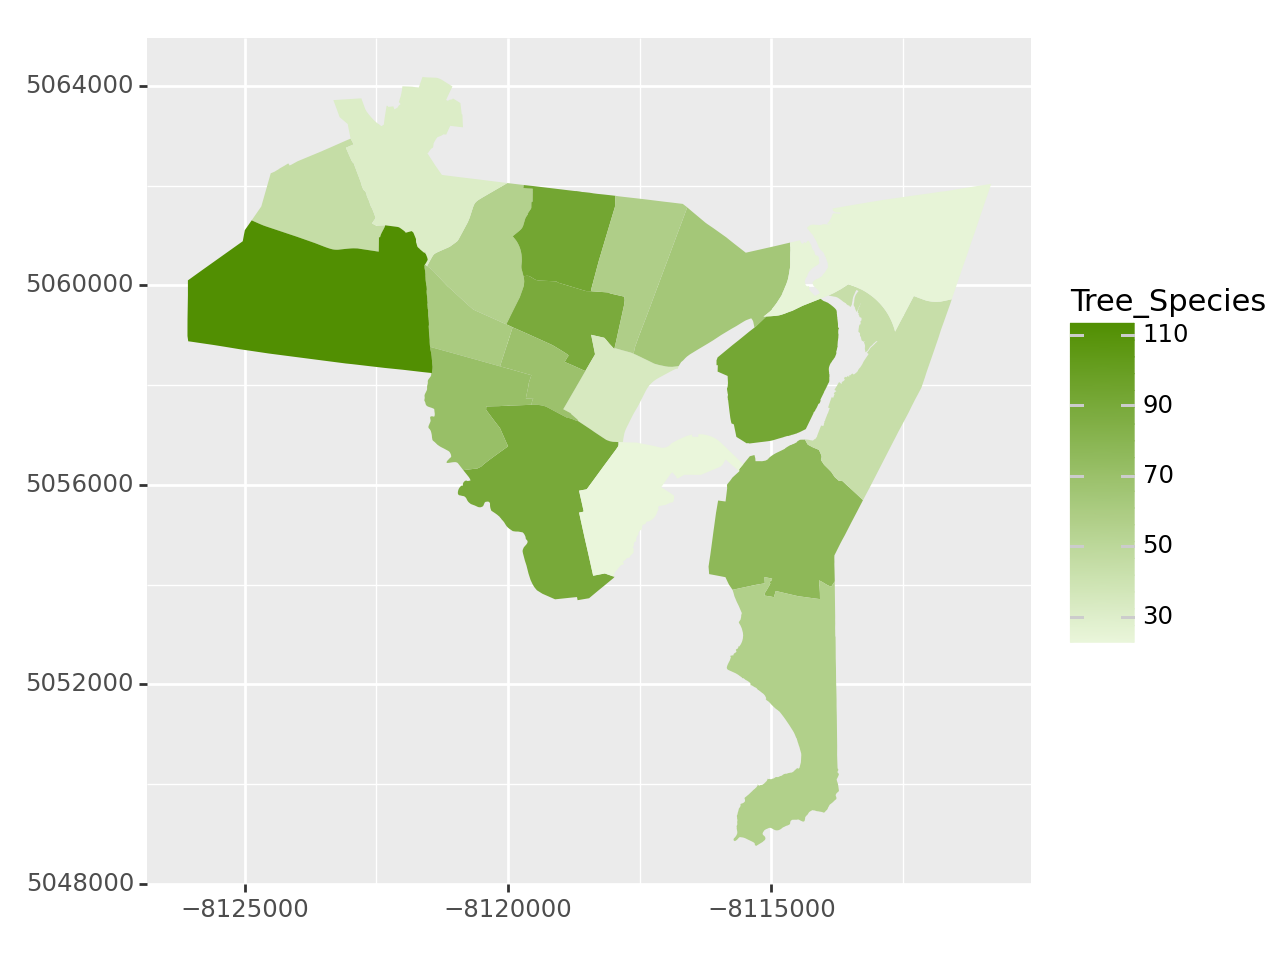

<Figure Size: (640 x 480)>

In [116]:
(
  ggplot()
   + geom_map(df_graph_clean, aes(geometry='geometry', fill="Tree_Species"),color=None)
   + scale_fill_gradient(low="#eaf6db", high="#518f02")
)


In [117]:
#Merge indexes with polygon for map
results_df

,Neighborhood,Shannon_Index,Simpson_Index
0,Amity,0.363204,0.096603
1,Annex,0.225626,0.009311
2,Beaver Hills,0.355660,0.076855
3,Cedar Hill,0.344657,0.060104
4,Dixwell,0.167166,0.003493
5,Downtown,0.306106,0.031142
6,Dwight,0.197842,0.005970
7,East Rock,0.301746,0.029127
8,East Shore,0.340560,0.055478
9,Edgewood,0.362973,0.184537


In [118]:
df_polygons = df_graph_clean[["Neighborhood", "geometry"]]
df_polygons

,Neighborhood,geometry
0,Amity,"POLYGON ((-8122986.721 5062944.439, -8122936.3..."
1,Annex,"POLYGON ((-8114363.662 5056907.349, -8114323.9..."
2,Beaver Hills,"POLYGON ((-8120010.855 5062053.576, -8119990.1..."
4,Dixwell,"POLYGON ((-8119801.427 5059109.589, -8119911.5..."
5,Downtown,"POLYGON ((-8118173.770 5058949.906, -8118143.2..."
6,Dwight,"POLYGON ((-8119801.427 5059109.589, -8119667.0..."
7,East Rock,"POLYGON ((-8116600.337 5061557.286, -8116597.6..."
8,East Shore,"POLYGON ((-8114096.393 5054084.117, -8114038.3..."
9,Edgewood,"POLYGON ((-8119911.510 5059160.851, -8119977.4..."
10,Fair Haven,"POLYGON ((-8115322.615 5059153.789, -8115294.4..."


In [119]:
df_graph2 = results_df.merge(df_polygons, how='outer', on='Neighborhood')

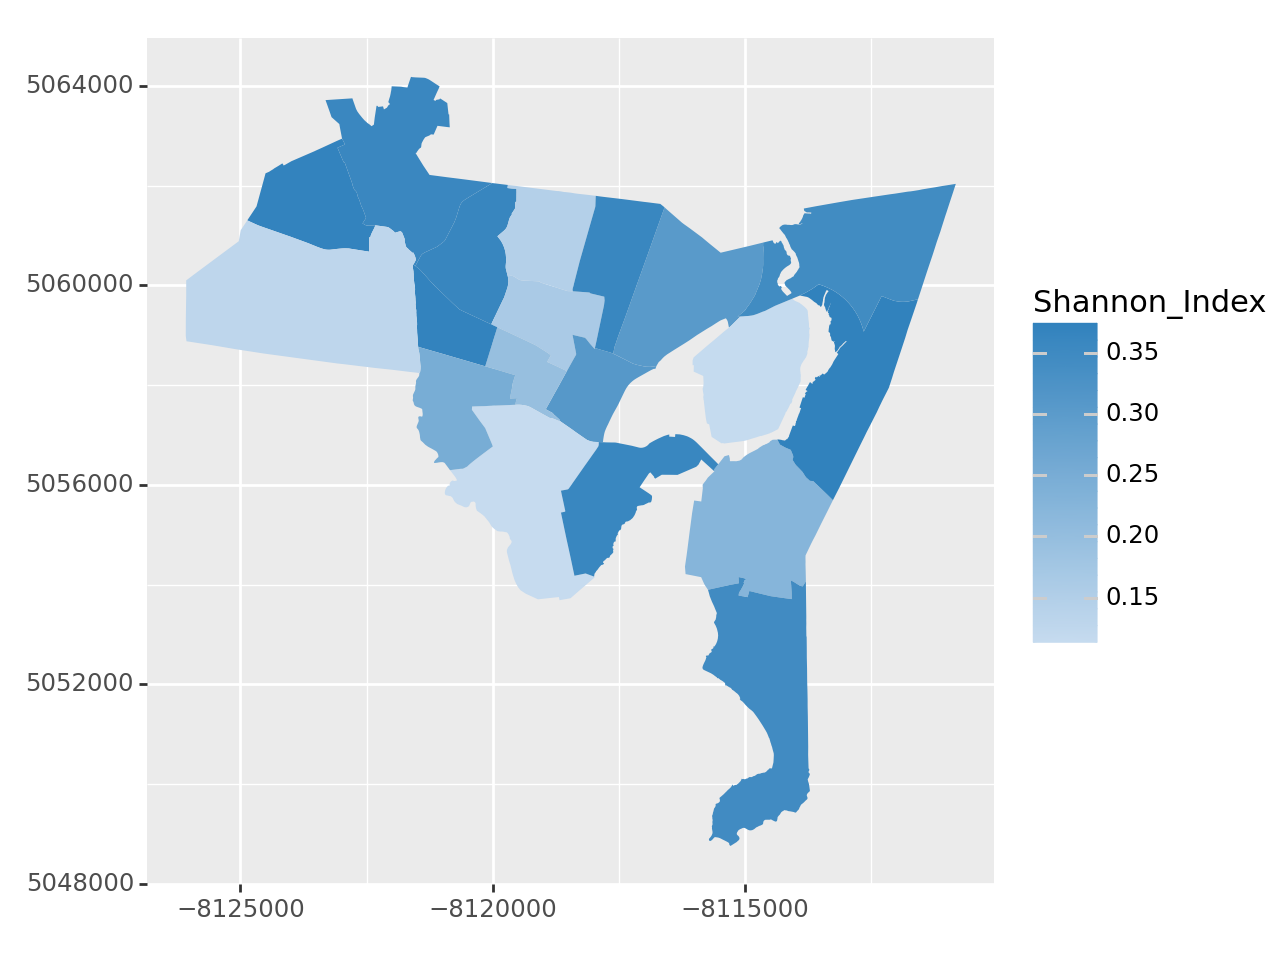

<Figure Size: (640 x 480)>

In [120]:
(
  ggplot()
   + geom_map(df_graph2, aes(geometry='geometry', fill="Shannon_Index"),color=None)
   + scale_fill_gradient(low="#c6dbef", high="#3182bd")
)

In [147]:
len(df_clean[df_clean.DBH<0])

0

In [123]:
df_clean.DBH.isna().sum()

0

In [124]:
# DataFrame with rows containing NaN values in the 'date' column
#df_before = df_clean[df_clean['Planted_Date'].isna()]
#df_before

In [125]:
# Sort the results DataFrame by Shannon_Index and Simpson_Index in descending order
sorted_results = results_df.sort_values(by=['Shannon_Index', 'Simpson_Index'], ascending=False)

# Get the top three neighborhoods with the highest Shannon_Index
top_three_shannon = sorted_results.nlargest(3, 'Shannon_Index')

# Get the top three neighborhoods with the highest Simpson_Index
top_three_simpson = sorted_results.nlargest(3, 'Simpson_Index')

print("Top three neighborhoods with the highest Shannon_Index:")
print(top_three_shannon)

print("\nTop three neighborhoods with the highest Simpson_Index:")
print(top_three_simpson)

Top three neighborhoods with the highest Shannon_Index:
          Neighborhood  Shannon_Index  Simpson_Index
11  Fair Haven Heights       0.367636       0.145432
0                Amity       0.363204       0.096603
9             Edgewood       0.362973       0.184537

Top three neighborhoods with the highest Simpson_Index:
          Neighborhood  Shannon_Index  Simpson_Index
16  Quinnipiac Meadows       0.340307       0.269601
18           West Rock       0.352765       0.228733
9             Edgewood       0.362973       0.184537


#### New Map for most common specie

For making this map we will be using 2 dataset: df_streets and nei_clean. We will merge this two datasets by "Neighborhood". We need to check that the names of the Neighborhoods are the same in both datasets.

In [149]:
# Check the neighborhoods
print("df_clean:",df_streets.Neighborhood.nunique())
print("clean_nei:",clean_nei.Neighborhood.nunique())

df_clean: 21
clean_nei: 19


The datasets do not have the same number of neighborhood, we will fix this

In [150]:
# Extract unique values of 'Neighborhood' column from each DataFrame
unique_neighborhoods_streets = set(df_clean['Neighborhood'].unique())
unique_neighborhoods_clean_nei = set(clean_nei['Neighborhood'].unique())

# Find differences
different_neighborhoods = unique_neighborhoods_streets.symmetric_difference(unique_neighborhoods_clean_nei)

# Print the different values
print("Different neighborhoods:")
for neighborhood in different_neighborhoods:
    print(neighborhood)

Different neighborhoods:
Wooster Square / Mill River
Cedar Hill


In [151]:
df_clean.Neighborhood.unique()

array(['Westville', 'Dixwell', 'West River', 'East Shore', 'Hill',
       'Dwight', 'Newhallville', 'East Rock', 'Annex', 'Fair Haven',
       'Prospect Hill', 'Wooster Square / Mill River', 'Beaver Hills',
       'Downtown', 'Edgewood', 'Long Wharf', 'Fair Haven Heights',
       'Quinnipiac Meadows', 'West Rock', 'Amity', 'Cedar Hill'],
      dtype=object)

We will drop "Wooster Square / Mill River" as we have drop these two neighborhoods in a previous step, while cleaning the Neighorhood database.

In [152]:
# Drop values
df_clean_map = df_clean[~((df_clean["Neighborhood"] == "Wooster Square / Mill River") | (df_clean["Neighborhood"] == "Cedar Hill"))]


In [153]:
# Check the neighborhoods
print("df_clean_map:",df_clean_map.Neighborhood.nunique())
print("clean_nei:",clean_nei.Neighborhood.nunique())

df_clean_map: 19
clean_nei: 19


In [154]:
# Merge datasets
df_map = df_clean_map.merge(clean_nei, how='outer', on='Neighborhood', indicator = True)

In [155]:
# Check merge
df_map._merge.unique()

['both']
Categories (3, object): ['left_only', 'right_only', 'both']

In [156]:
# Drop _merge column
df_map = df_map.drop("_merge",axis=1)

In [157]:
# df_map is the data set that contains the
df_map.columns

Index(['Site_ID', 'Latitude', 'Longitude', 'Latin_Name', 'Common_Name',
       'Condition', 'DBH', 'Wire', 'Grow_Space', 'Planting Organization',
       'Neighborhood', 'Planted Date', 'Department', 'Genus',
       '(Common) Species (Genus)', 'Last_Editor', 'Valuation_Total',
       'Valuation Type', 'Sites', 'OBJECTID', 'ACRES', 'Neighborho',
       'Shape_area', 'Shape_len', 'Shape__Are', 'Shape__Len', 'UTC_2016',
       'geometry'],
      dtype='object')

In [ ]:
# Data frame filtering only streets- General data of streets with `polygons
df_map_streets = df_map[df_map["Department"] == "Street Tree"]
df_map_streets

In [ ]:
# boobo
# Species and neighborhoods  of trees in New Haven
df_a = df_map_streets.groupby(['Neighborhood','Latin_Name']).agg(Trees_Species = ('Latin_Name','count')).reset_index()
df_cond=df_a.pivot(index='Neighborhood', columns='Latin_Name', values='Trees_Species').reset_index()
df_cond.head()

In [315]:
# Create DataFrame
dfm = pd.DataFrame(df_cond)
dfm= dfm.fillna(0)

# Function to find the column name with the highest value for each row
def get_max_column(row):
    max_value = max(row[1:])  # Exclude the Neighborhood column
    return dfm.columns[1:][row[1:].values.argmax()] if max_value == max_value else None

# Apply the function to each row
dfm['Highest_Value_Column'] = dfm.apply(get_max_column, axis=1)

# Resulting DataFrame
print(dfm[['Neighborhood', 'Highest_Value_Column']])

Latin_Name        Neighborhood   Highest_Value_Column
0                        Amity      Quercus palustris
1                        Annex      Quercus palustris
2                 Beaver Hills      Maackia amurensis
3                      Dixwell  Platanus x acerifolia
4                     Downtown  Platanus x acerifolia
5                       Dwight  Gleditsia triacanthos
6                    East Rock        Amelanchier spp
7                   East Shore      Quercus palustris
8                     Edgewood            Acer rubrum
9                   Fair Haven  Platanus x acerifolia
10          Fair Haven Heights     Syringa reticulata
11                        Hill  Platanus x acerifolia
12                  Long Wharf  Platanus x acerifolia
13                Newhallville      Quercus palustris
14               Prospect Hill   Carpinus caroliniana
15          Quinnipiac Meadows         Crataegus spp.
16                  West River      Quercus palustris
17                   West Ro

In [316]:
df_a.head()

,Neighborhood,Latin_Name,Trees_Species
0,Amity,Acer buergerianum,2
1,Amity,Acer miyabei,2
2,Amity,Acer platanoides,1
3,Amity,Acer saccharinum,2
4,Amity,Acer x freemanii,1


In [200]:
# Merge data of species with geometry
df_map_streets_geom = df_cond.merge(clean_nei, how='outer', on='Neighborhood', indicator = True)

In [309]:
df_map_streets_geom

,Neighborhood,Abies concolor,Abies spp.,Acer buergerianum,Acer campestre,Acer ginnala,Acer griseum,Acer miyabei,Acer negundo,Acer palmatum,...,OBJECTID,ACRES,Neighborho,Shape_area,Shape_len,Shape__Are,Shape__Len,UTC_2016,geometry,_merge
0,Amity,NaN,NaN,2.0,NaN,NaN,NaN,2.0,NaN,NaN,...,12,470.91,AMITY,2.051293e+07,19865.718411,3.383045e+06,8065.737875,.36,"POLYGON ((-8122986.721 5062944.439, -8122936.3...",both
1,Annex,NaN,NaN,12.0,4.0,NaN,NaN,3.0,NaN,NaN,...,22,877.07,ANNEX,3.820526e+07,27866.216819,6.292540e+06,11311.987361,.19,"POLYGON ((-8114363.662 5056907.349, -8114323.9...",both
2,Beaver Hills,NaN,NaN,NaN,1.0,1.0,NaN,3.0,NaN,NaN,...,13,442.60,BEAVER HILLS,1.927978e+07,19328.539681,3.178991e+06,7851.203088,.33,"POLYGON ((-8120010.855 5062053.576, -8119990.1...",both
3,Dixwell,NaN,NaN,11.0,10.0,NaN,1.0,2.0,NaN,NaN,...,7,336.78,DIXWELL,1.475696e+07,18107.206310,2.432593e+06,7350.678432,.21,"POLYGON ((-8119801.427 5059109.589, -8119911.5...",both
4,Downtown,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,9,302.08,DOWNTOWN,1.315854e+07,16821.576475,2.168458e+06,6828.556824,.17,"POLYGON ((-8118173.770 5058949.906, -8118143.2...",both
5,Dwight,NaN,NaN,6.0,1.0,NaN,1.0,3.0,NaN,NaN,...,8,202.58,DWIGHT,8.824339e+06,15305.198643,1.454318e+06,6212.201826,.19,"POLYGON ((-8119801.427 5059109.589, -8119667.0...",both
6,East Rock,NaN,NaN,8.0,6.0,NaN,3.0,6.0,NaN,NaN,...,17,714.54,EAST-ROCK,3.112518e+07,25207.884217,5.131341e+06,10237.642445,.36,"POLYGON ((-8116600.337 5061557.286, -8116597.6...",both
7,East Shore,NaN,NaN,5.0,5.0,1.0,1.0,2.0,NaN,NaN,...,23,966.00,EAST-SHORE,4.207874e+07,42134.328063,6.925477e+06,17101.968810,.22,"POLYGON ((-8114096.393 5054084.117, -8114038.3...",both
8,Edgewood,NaN,NaN,2.0,NaN,NaN,NaN,2.0,NaN,NaN,...,10,237.69,EDGEWOOD,1.035363e+07,14738.643104,1.706680e+06,5985.096078,.34,"POLYGON ((-8119911.510 5059160.851, -8119977.4...",both
9,Fair Haven,NaN,NaN,7.0,19.0,NaN,9.0,7.0,NaN,NaN,...,3,635.72,FAIR-HAVEN,2.769194e+07,20954.100871,4.563816e+06,8508.526877,.13,"POLYGON ((-8115322.615 5059153.789, -8115294.4...",both


In [173]:
# Check merge
df_map_streets_geom._merge.unique()

['both']
Categories (3, object): ['left_only', 'right_only', 'both']

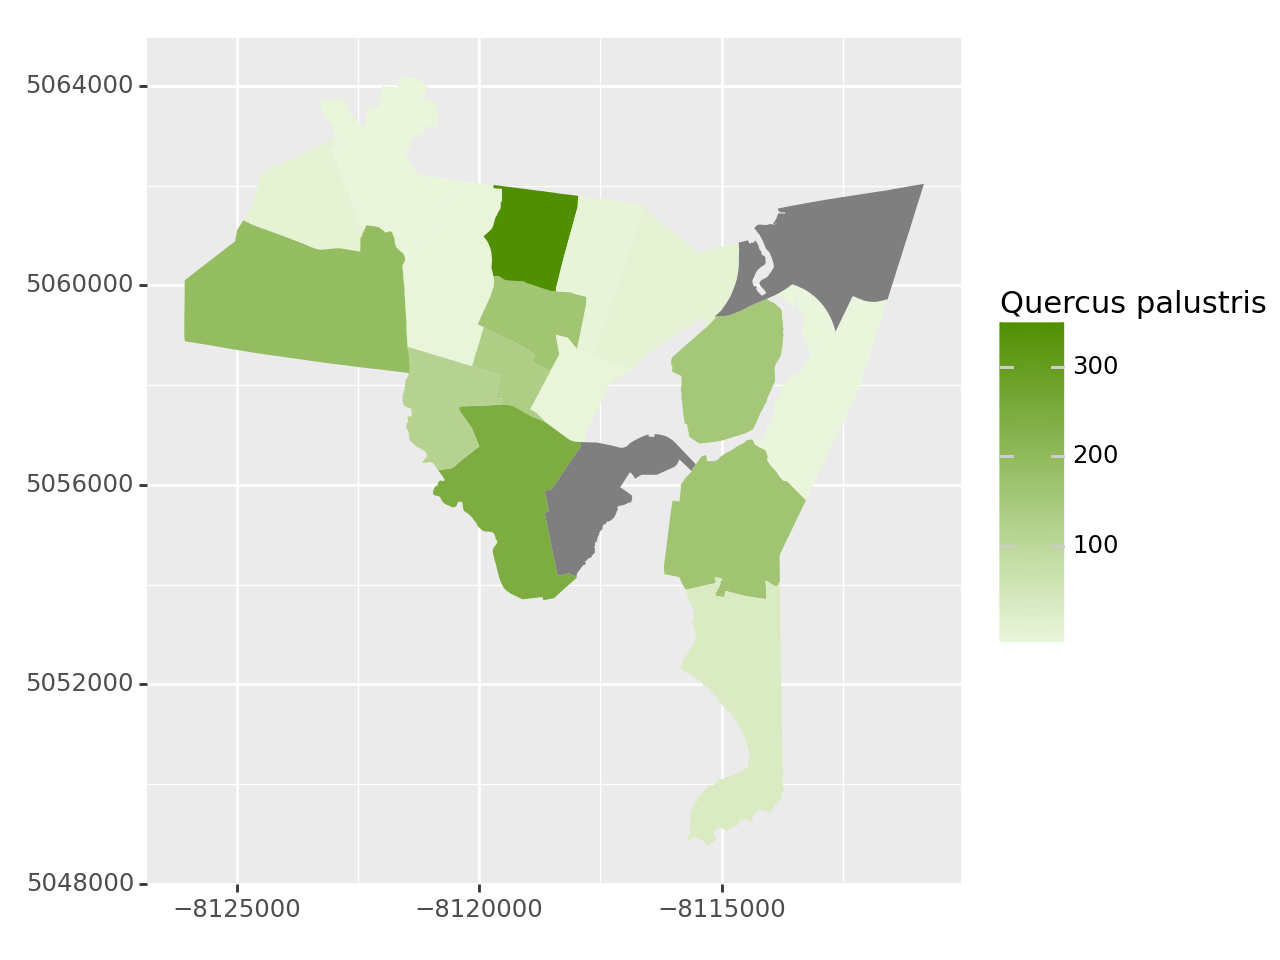

<Figure Size: (640 x 480)>

In [175]:
# Create the map with most common species
(
  ggplot()
   + geom_map(df_map_streets_geom, aes(geometry='geometry', fill="Quercus palustris"),color=None)
   + scale_fill_gradient(low="#eaf6db", high="#518f02")
)

### Bar plot del porcentje de arboles en buenas y malas condiciones por barrio

In [248]:
df_bar = df_clean[~((df_clean["Neighborhood"] == "Wooster Square / Mill River") | (df_clean["Neighborhood"] == "Cedar Hill"))]


In [255]:
# Calculate the total number of trees in each neighborhood
total_trees_neighborhood = df_bar.groupby('Neighborhood')['Latin_Name'].count()

# Calculate the percentage of trees in each condition for each neighborhood
df_a = df_bar.groupby(['Neighborhood', 'Condition'])['Latin_Name'].count() / total_trees_neighborhood * 100
df_a = df_a.reset_index(name='Trees_Condition_Percentage')

# Pivot the DataFrame to have neighborhoods as rows and conditions as columns
df_cond = df_a.pivot(index='Neighborhood', columns='Condition', values='Trees_Condition_Percentage').reset_index()

# Fill NaN values with 0
#df_cond = df_cond.fillna(0)


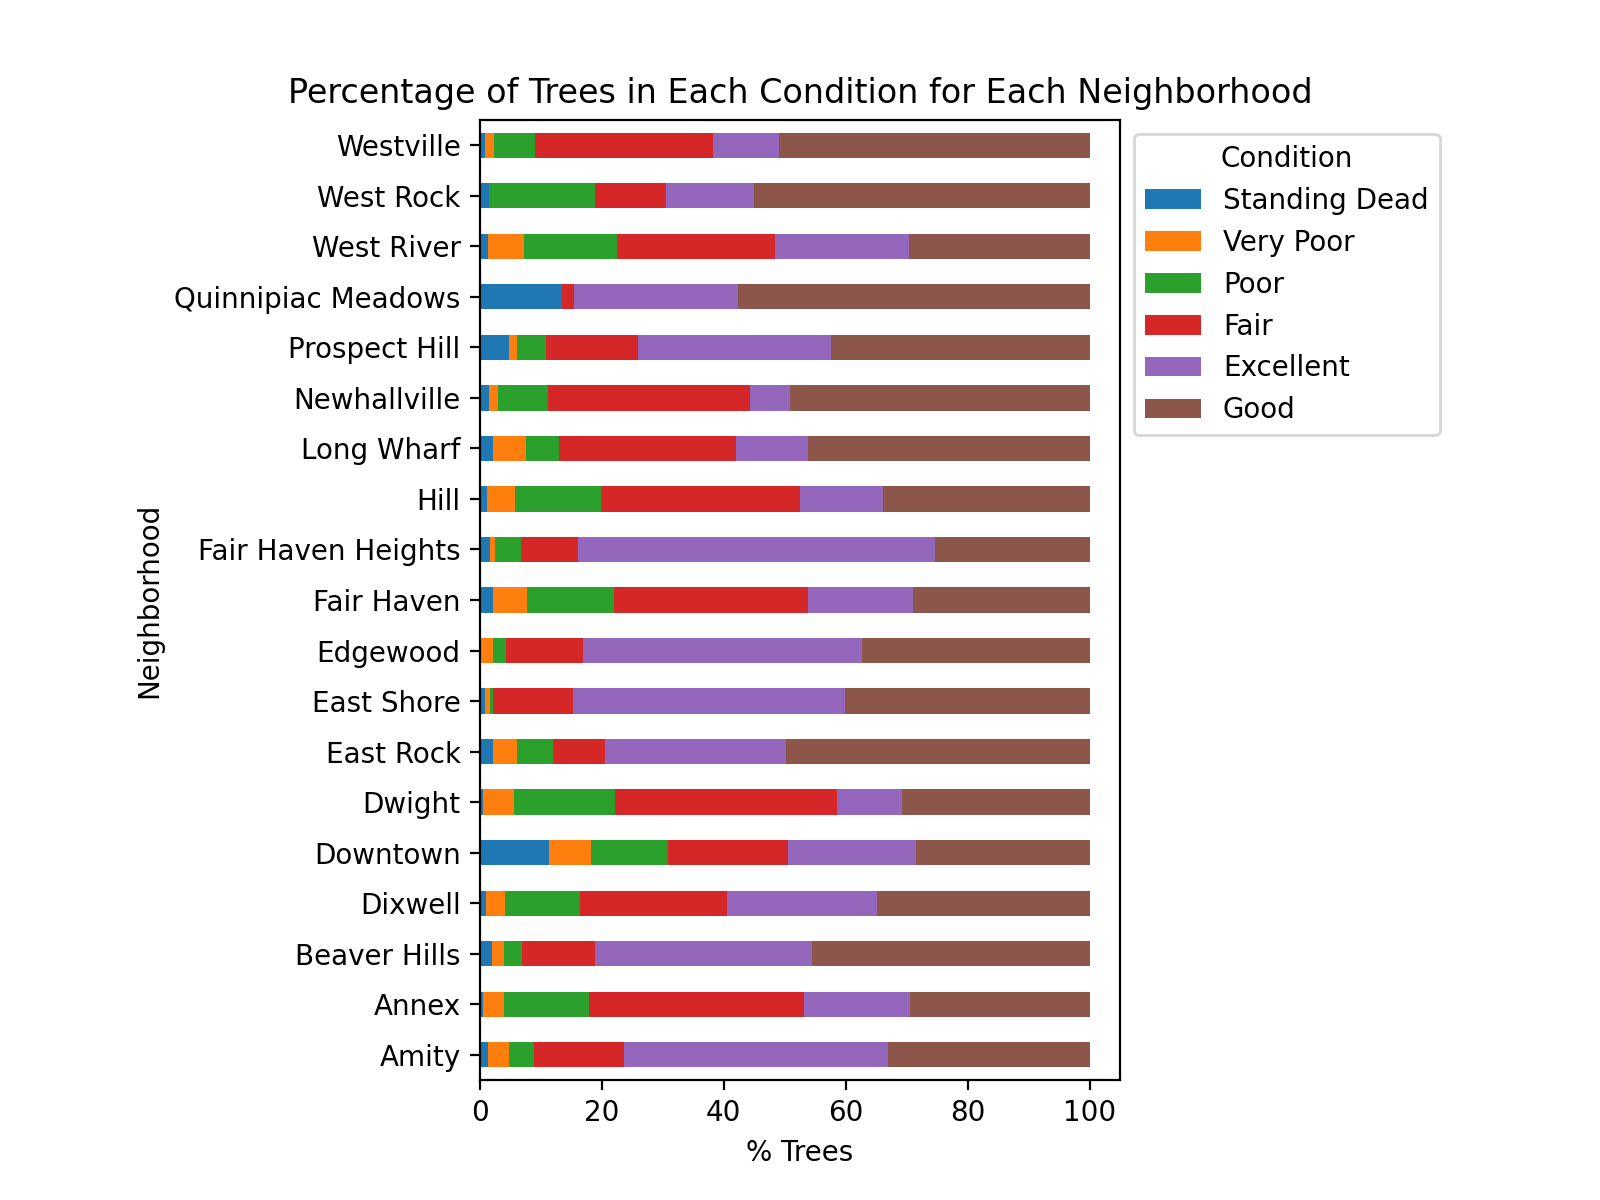

In [265]:
# Assuming df_cond is your DataFrame containing the percentages of trees in each condition for each neighborhood

# Set the neighborhood column as the index for plotting
#df_cond.set_index('Neighborhood', inplace=True)

# Reorder the columns of df_cond so that the conditions with lower values are shown first
df_cond_percent = df_cond[df_cond.sum().sort_values().index]

# Plot the DataFrame as a stacked bar plot
ax = df_cond_percent.plot(kind='barh', stacked=True, figsize=(8, 6))

# Add labels and title
plt.title('Percentage of Trees in Each Condition for Each Neighborhood')
plt.xlabel('% Trees')
plt.ylabel('Neighborhood')

# Add legend
plt.legend(title='Condition', bbox_to_anchor=(1, 1), loc='upper left')

# Adjust margins to expand the display area
plt.subplots_adjust(left=0.3, right=0.7, top=0.9, bottom=0.1)

# Show plot
plt.show()

In [301]:
df_cond_percent

Condition,Standing Dead,Very Poor,Poor,Fair,Excellent,Good
Neighborhood,,,,,,
Amity,1.351351,3.378378,4.054054,14.864865,43.243243,33.108108
Annex,0.501253,3.508772,13.909774,35.213033,17.418546,29.448622
Beaver Hills,1.980198,1.980198,2.970297,11.881188,35.643564,45.544554
Dixwell,0.940228,3.089322,12.357287,24.177300,24.513096,34.922767
Downtown,11.274510,6.862745,12.745098,19.607843,21.078431,28.431373
Dwight,0.559910,5.039194,16.573348,36.394177,10.638298,30.795073
East Rock,2.133333,4.000000,5.866667,8.533333,29.600000,49.866667
East Shore,0.826446,0.826446,0.413223,13.223140,44.628099,40.082645
Edgewood,NaN,2.112676,2.112676,12.676056,45.774648,37.323944


In [279]:
df_map_prueba= df_cond.merge(clean_nei, how='outer', on='Neighborhood', indicator = True)

In [280]:
df_map_prueba.head()

,Neighborhood,Standing Dead,Very Poor,Poor,Fair,Excellent,Good,OBJECTID,ACRES,Neighborho,Shape_area,Shape_len,Shape__Are,Shape__Len,UTC_2016,geometry,_merge
0,Amity,1.351351,3.378378,4.054054,14.864865,43.243243,33.108108,12,470.91,AMITY,2.051293e+07,19865.718411,3.383045e+06,8065.737875,.36,"POLYGON ((-8122986.721 5062944.439, -8122936.3...",both
1,Annex,0.501253,3.508772,13.909774,35.213033,17.418546,29.448622,22,877.07,ANNEX,3.820526e+07,27866.216819,6.292540e+06,11311.987361,.19,"POLYGON ((-8114363.662 5056907.349, -8114323.9...",both
2,Beaver Hills,1.980198,1.980198,2.970297,11.881188,35.643564,45.544554,13,442.60,BEAVER HILLS,1.927978e+07,19328.539681,3.178991e+06,7851.203088,.33,"POLYGON ((-8120010.855 5062053.576, -8119990.1...",both
3,Dixwell,0.940228,3.089322,12.357287,24.177300,24.513096,34.922767,7,336.78,DIXWELL,1.475696e+07,18107.206310,2.432593e+06,7350.678432,.21,"POLYGON ((-8119801.427 5059109.589, -8119911.5...",both
4,Downtown,11.274510,6.862745,12.745098,19.607843,21.078431,28.431373,9,302.08,DOWNTOWN,1.315854e+07,16821.576475,2.168458e+06,6828.556824,.17,"POLYGON ((-8118173.770 5058949.906, -8118143.2...",both


In [ ]:
# Calculate the maximum value of the "Poor" column
max_value = df_map_prueba['Poor'].max()
# Map of percentage of trees that are in poor conditions
(
  ggplot()
   + geom_map(df_map_prueba, aes(geometry='geometry', fill="Poor"),color=None)
   + scale_fill_gradient(low="#c6dbef", high="#3182bd")
   + geom_map(df_map_prueba[df_map_prueba['Poor'] == max_value], aes(geometry='geometry'), fill="red")
  )

In [ ]:
# Calculate the maximum value of the "Good" column
max_value = df_map_prueba['Good'].max()
# Map of percentage of trees that are in Good conditions
(
  ggplot()
   + geom_map(df_map_prueba, aes(geometry='geometry', fill="Good"),color=None)
   + scale_fill_gradient(low="#c6dbef", high="#3182bd")
   + geom_map(df_map_prueba[df_map_prueba['Excellent'] == max_value], aes(geometry='geometry'), fill="red")
  )


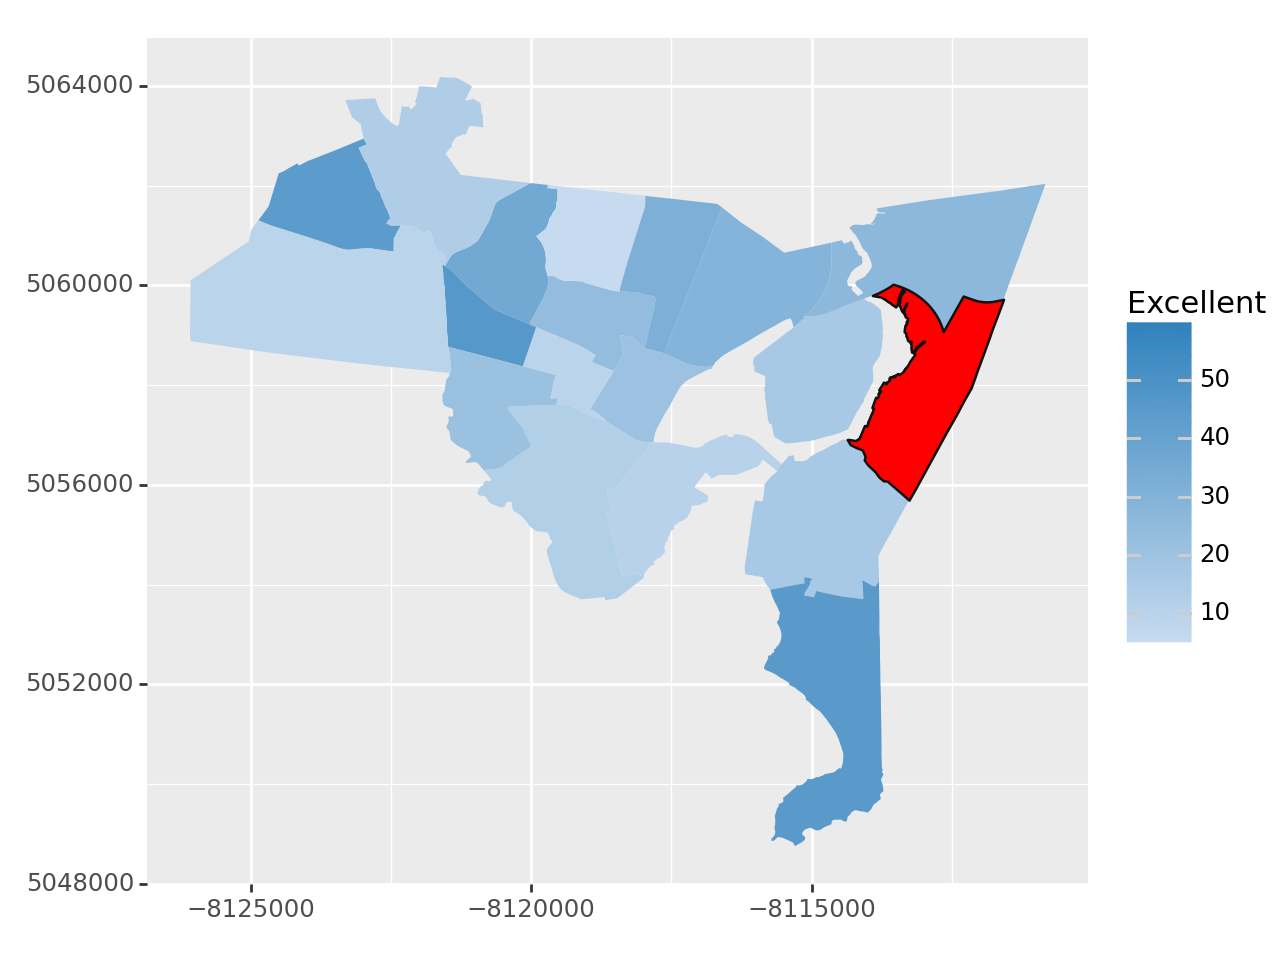

<Figure Size: (640 x 480)>

In [300]:
# Calculate the maximum value of the "Excellent" column
max_value = df_map_prueba['Excellent'].max()
# Map of percentage of trees that are in Excellent conditions
(
  ggplot()
   + geom_map(df_map_prueba, aes(geometry='geometry', fill="Excellent"),color=None)
   + scale_fill_gradient(low="#c6dbef", high="#3182bd")
   + geom_map(df_map_prueba[df_map_prueba['Excellent'] == max_value], aes(geometry='geometry'), fill="red")
  )

In [ ]:
# Create the map with most common species
(
  ggplot()
   + geom_map(df_map_streets_geom, aes(geometry='geometry', fill="Quercus palustris"),color=None)
   + scale_fill_gradient(low="#eaf6db", high="#518f02")
)

In [259]:
df_cond

Condition,Standing Dead,Very Poor,Poor,Fair,Excellent,Good
Neighborhood,,,,,,
Amity,1.351351,3.378378,4.054054,14.864865,43.243243,33.108108
Annex,0.501253,3.508772,13.909774,35.213033,17.418546,29.448622
Beaver Hills,1.980198,1.980198,2.970297,11.881188,35.643564,45.544554
Dixwell,0.940228,3.089322,12.357287,24.177300,24.513096,34.922767
Downtown,11.274510,6.862745,12.745098,19.607843,21.078431,28.431373
Dwight,0.559910,5.039194,16.573348,36.394177,10.638298,30.795073
East Rock,2.133333,4.000000,5.866667,8.533333,29.600000,49.866667
East Shore,0.826446,0.826446,0.413223,13.223140,44.628099,40.082645
Edgewood,NaN,2.112676,2.112676,12.676056,45.774648,37.323944


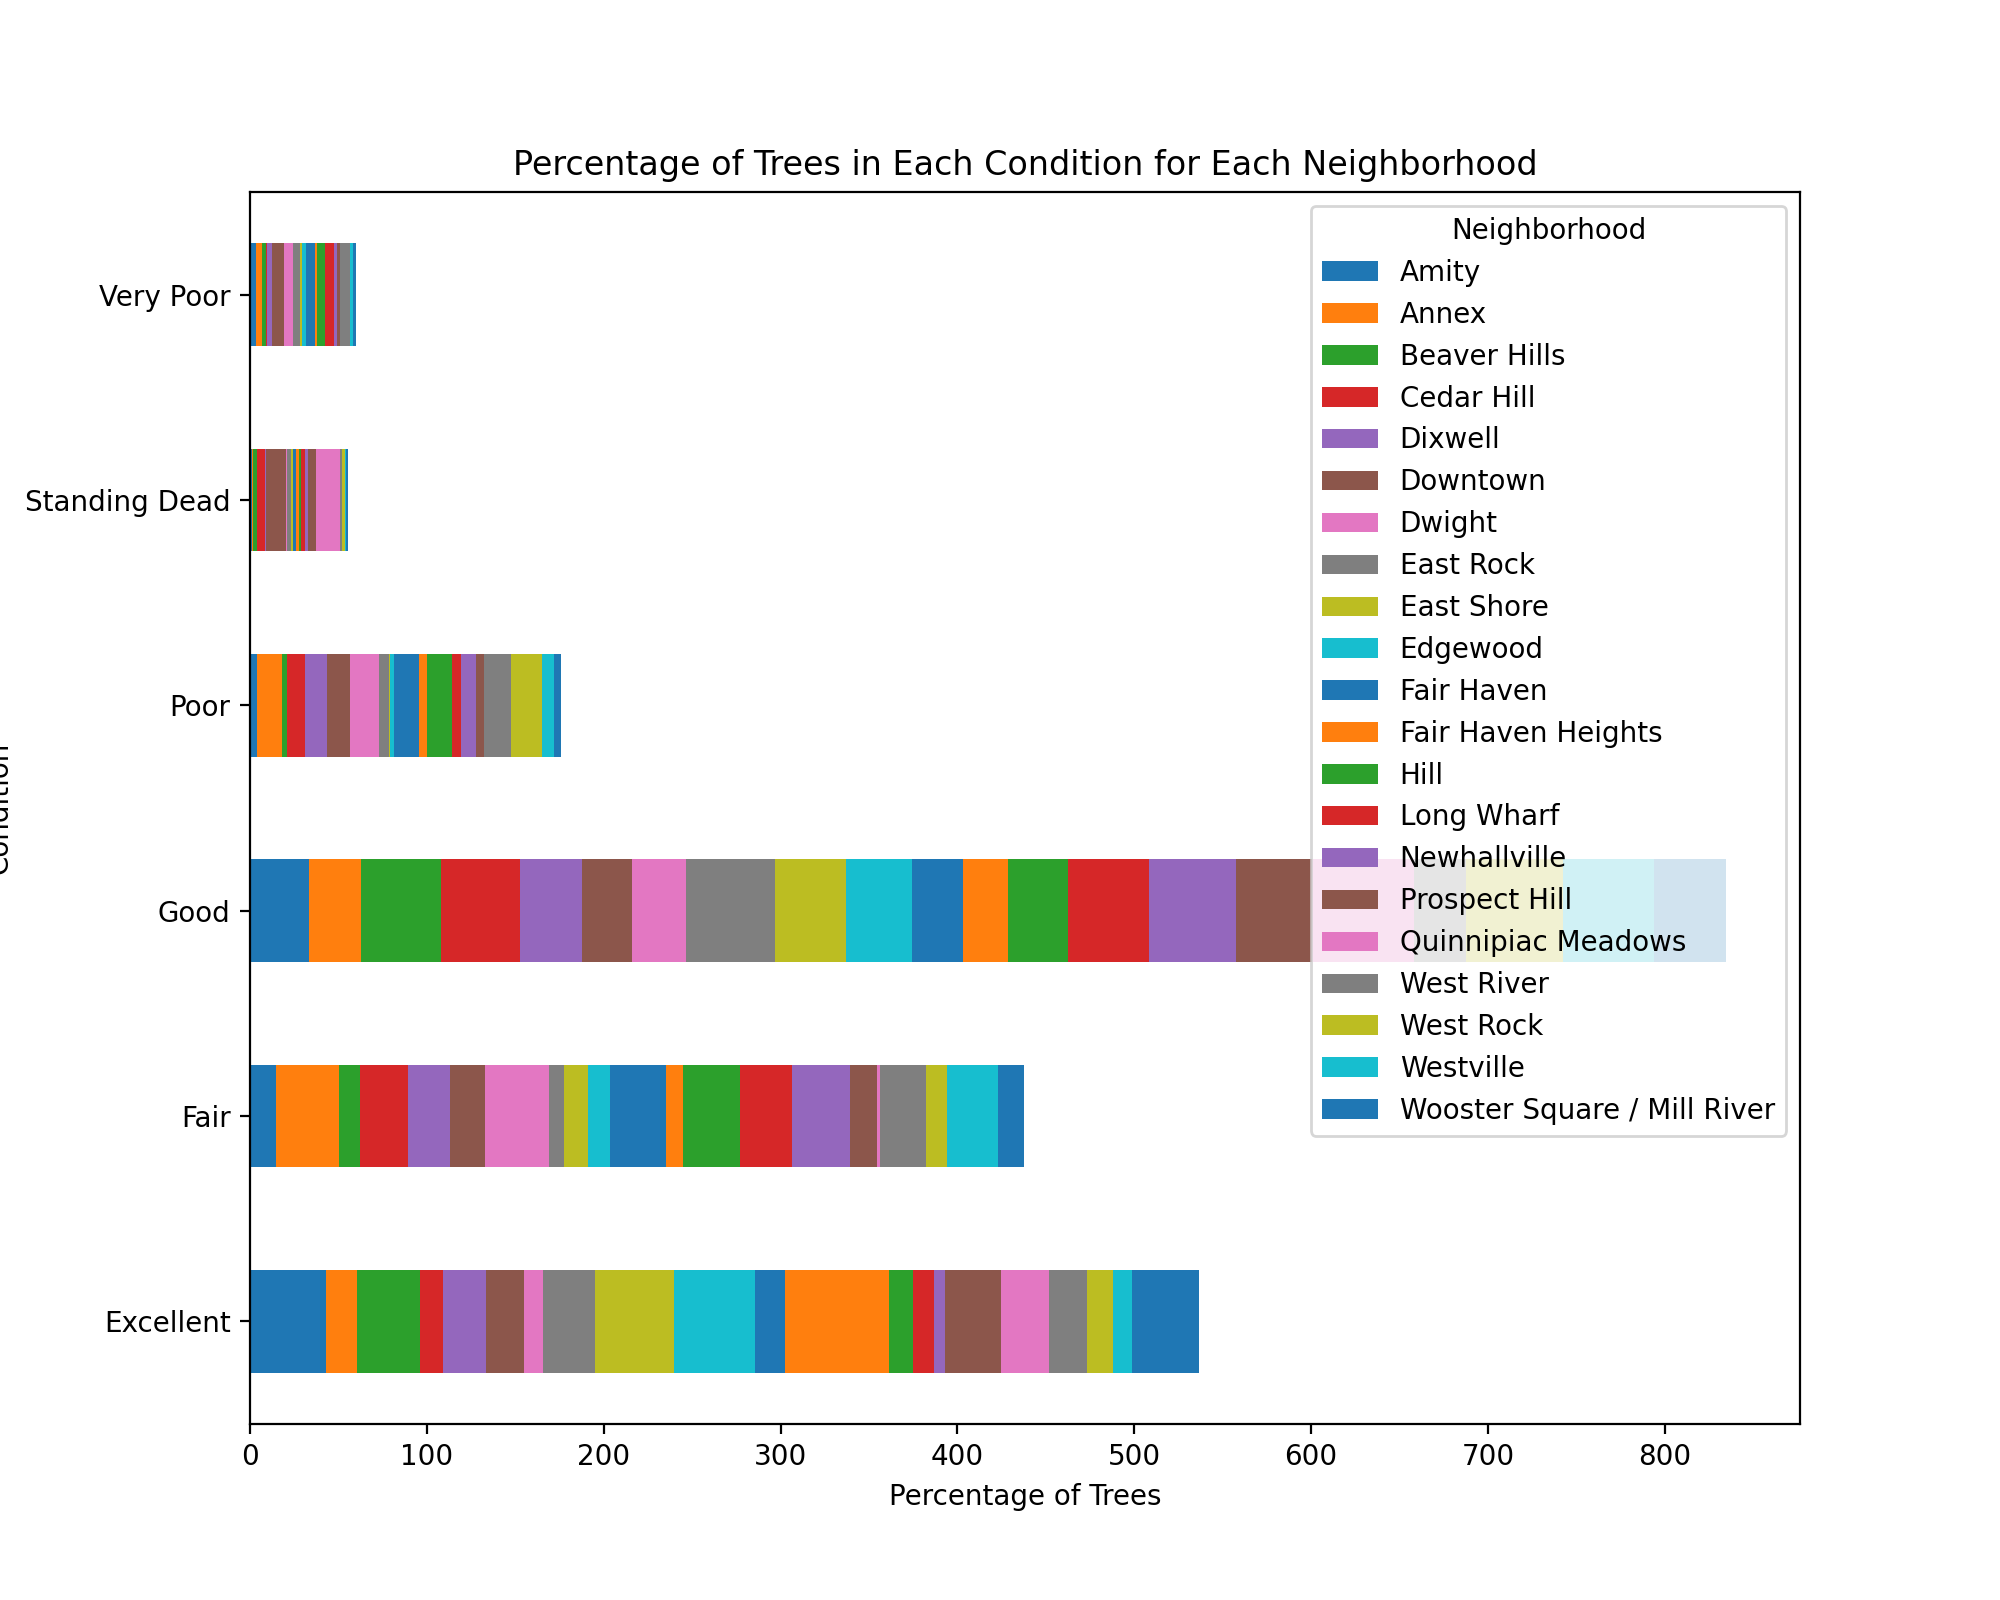

In [206]:
# Transpose the DataFrame
df_transposed = df_cond.T

# Plot the transposed DataFrame as a horizontal bar plot
ax = df_transposed.plot(kind='barh', stacked=True, figsize=(10, 8))

# Add labels and title
plt.title('Percentage of Trees in Each Condition for Each Neighborhood')
plt.xlabel('Percentage of Trees')
plt.ylabel('Condition')

# Add legend
plt.legend(title='Neighborhood')

# Show plot
plt.show()

In [202]:
import matplotlib.pyplot as plt

# Assuming df_cond is your DataFrame containing the percentages of trees in each condition for each neighborhood

# Set the neighborhood column as the index for plotting
df_cond.set_index('Neighborhood', inplace=True)

# Plot the DataFrame as a stacked bar plot
ax = df_cond.plot(kind='bar', stacked=True, figsize=(10, 6))


# Add labels and title
plt.title('Percentage of Trees in Each Condition for Each Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Percentage of Trees')

# Add legend
plt.legend(title='Condition')

# Show plot
plt.show()

KeyError: "None of ['Neighborhood'] are in the columns"

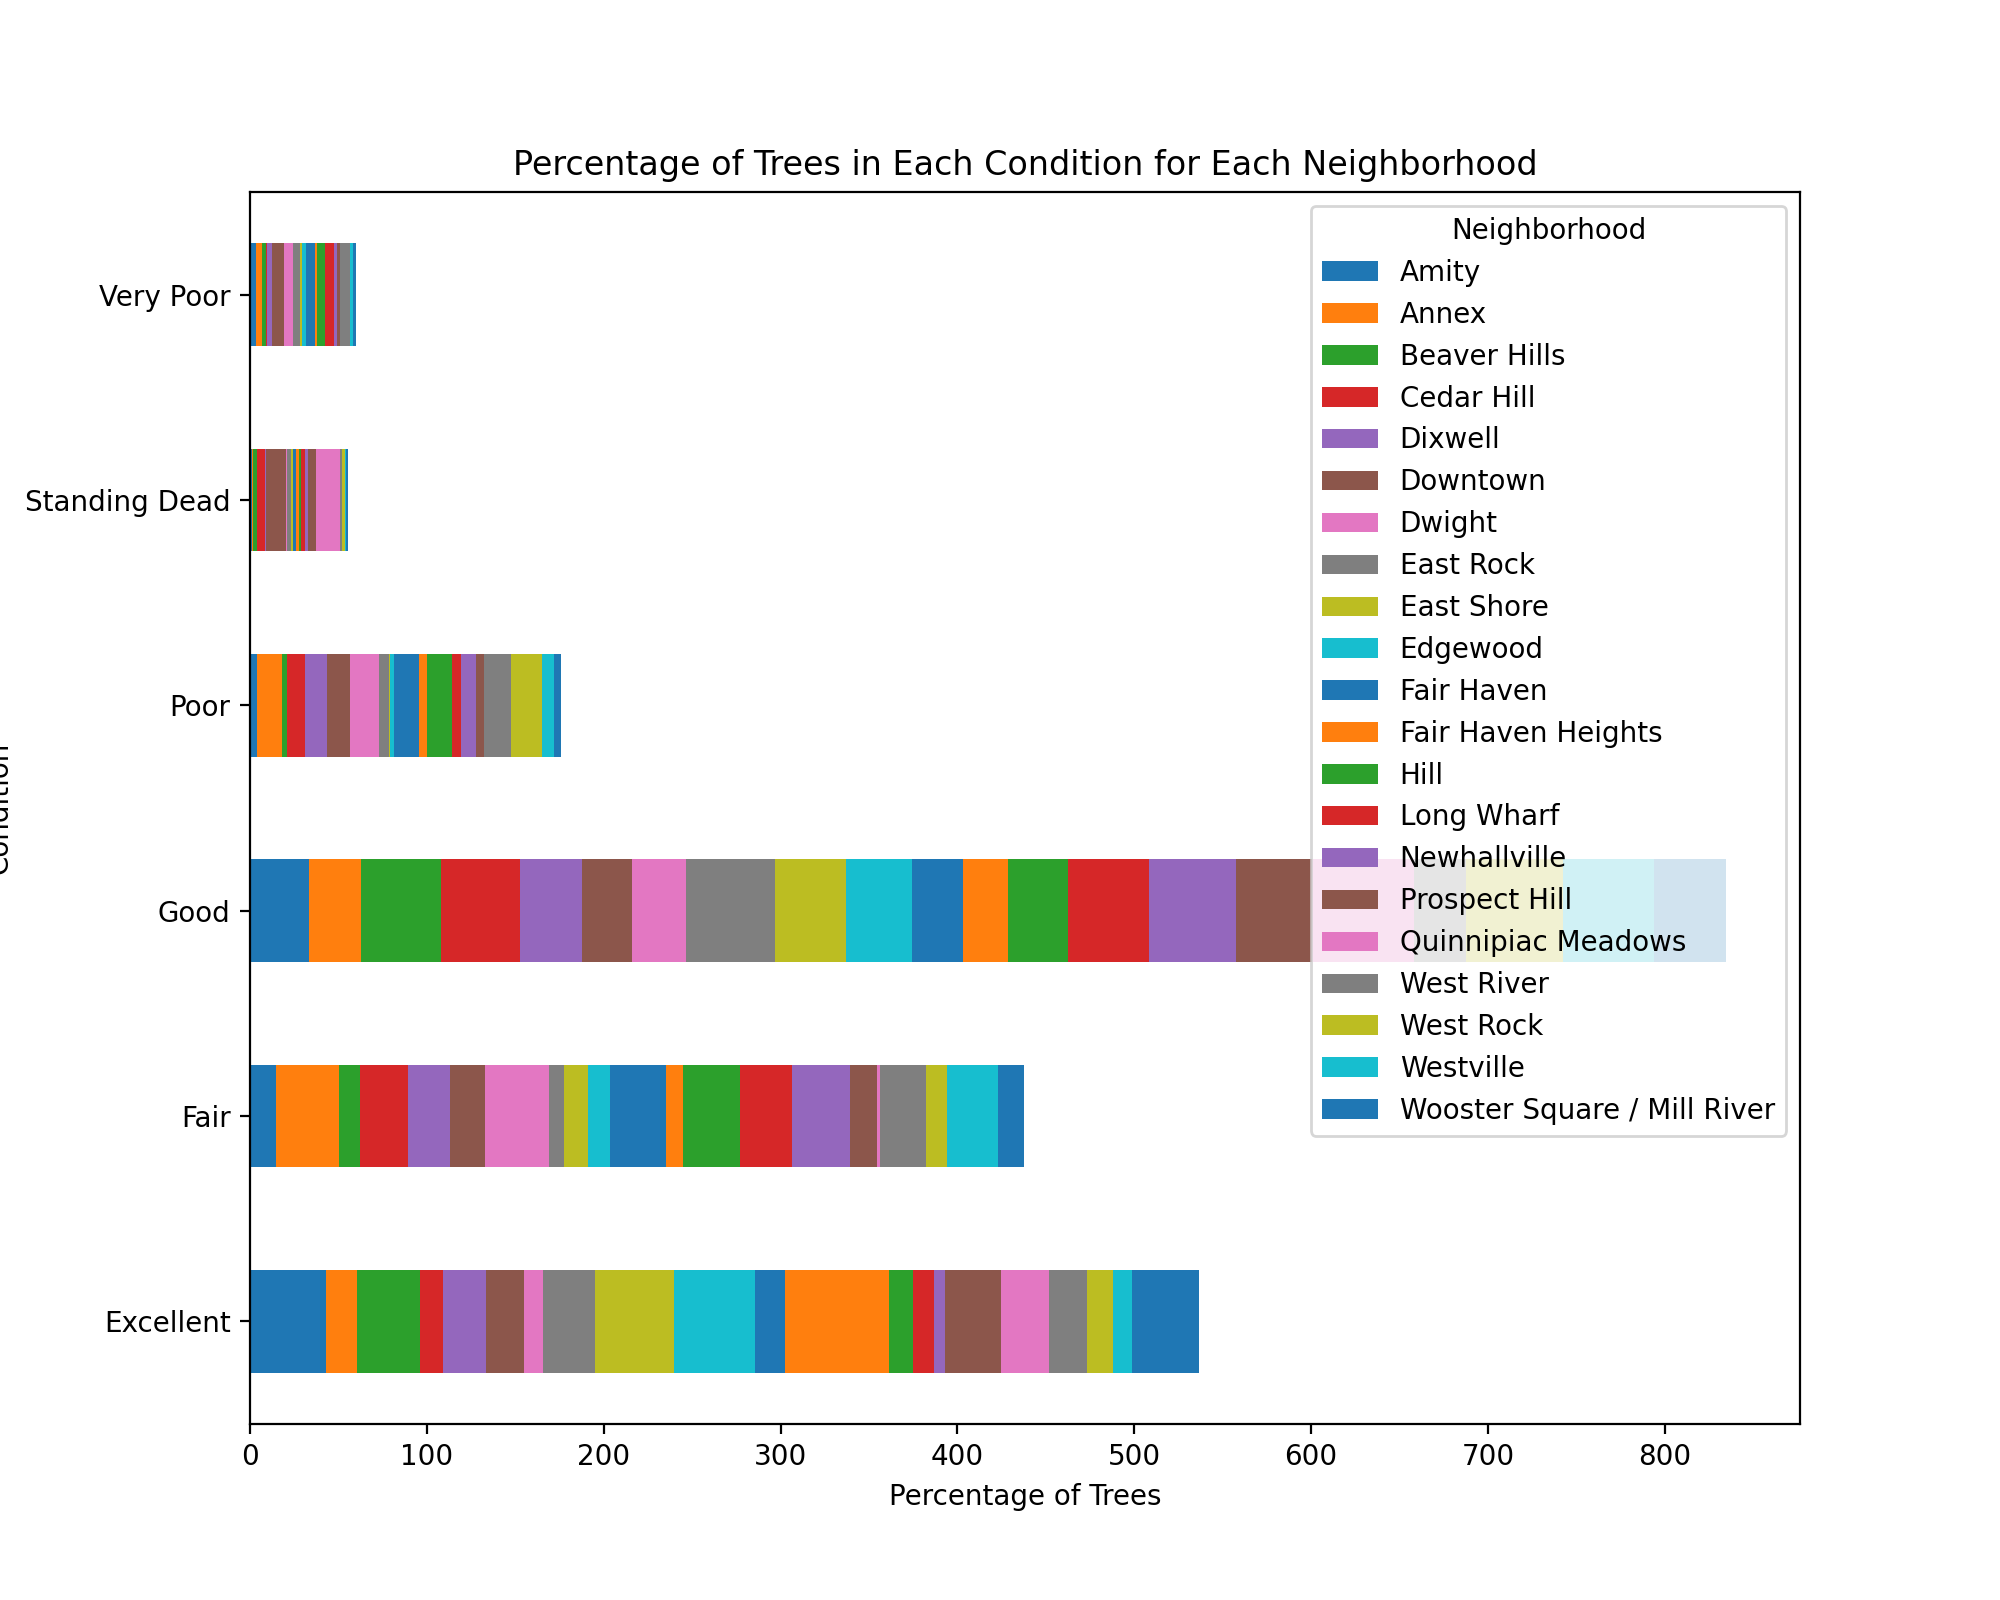

In [187]:
# Reset the index to make 'Neighborhood' a regular column
df_cond_reset = df_cond.reset_index()

# Transpose the DataFrame
df_transposed = df_cond_reset.set_index('Neighborhood').T

# Plot the transposed DataFrame as a horizontal bar plot
ax = df_transposed.plot(kind='barh', stacked=True, figsize=(10, 8))

# Add labels and title
plt.title('Percentage of Trees in Each Condition for Each Neighborhood')
plt.xlabel('Percentage of Trees')
plt.ylabel('Condition')

# Add legend
plt.legend(title='Neighborhood')

# Show plot
plt.show()

In [ ]:
# Extra code (Exploring data)
df_clean.groupby(['Neighborhood', "Latin_Name"]).agg(Trees=('Latin_Name','count')).reset_index()



In [161]:
df_cond

Latin_Name,Neighborhood,Abies concolor,Abies spp.,Acer buergerianum,Acer campestre,Acer ginnala,Acer griseum,Acer miyabei,Acer negundo,Acer palmatum,...,Tilia cordata,Tilia euchlora,Tilia spp.,Tilia tomentosa,Ulmus americana,Ulmus carpinifolia 'hollandica',Ulmus parvifolia,Ulmus pumila,Ulmus spp.,Zelkova serrata
0,Amity,NaN,NaN,2.0,NaN,NaN,NaN,2.0,NaN,NaN,...,1.0,NaN,NaN,2.0,2.0,NaN,5.0,NaN,2.0,NaN
1,Annex,NaN,NaN,12.0,5.0,NaN,NaN,3.0,NaN,NaN,...,34.0,NaN,2.0,1.0,5.0,NaN,5.0,16.0,3.0,2.0
2,Beaver Hills,NaN,NaN,NaN,1.0,1.0,NaN,3.0,NaN,NaN,...,4.0,NaN,1.0,1.0,1.0,NaN,9.0,NaN,NaN,5.0
3,Cedar Hill,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,28.0,NaN,NaN,1.0,2.0,NaN,NaN,NaN,1.0,1.0
4,Dixwell,NaN,NaN,11.0,10.0,NaN,1.0,2.0,NaN,NaN,...,51.0,NaN,NaN,1.0,30.0,NaN,19.0,7.0,34.0,53.0
5,Downtown,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,NaN,NaN,15.0,NaN,11.0,NaN,12.0,4.0
6,Dwight,NaN,NaN,6.0,1.0,NaN,1.0,3.0,NaN,NaN,...,35.0,NaN,1.0,2.0,48.0,1.0,2.0,23.0,20.0,25.0
7,East Rock,NaN,NaN,9.0,6.0,NaN,3.0,6.0,NaN,NaN,...,9.0,2.0,2.0,2.0,NaN,NaN,10.0,2.0,7.0,4.0
8,East Shore,NaN,NaN,5.0,5.0,1.0,1.0,2.0,NaN,NaN,...,5.0,NaN,1.0,1.0,NaN,NaN,3.0,NaN,8.0,1.0
9,Edgewood,NaN,NaN,2.0,NaN,NaN,NaN,2.0,NaN,NaN,...,6.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,3.0,4.0


In [ ]:
df_tab= df_neig.merge(df_species, how='outer', on='Neighborhood', indicator = True)
df_tab

In [111]:
# Replace values
streets_clean['Neighborhood'] = streets_clean['Neighborhood'].replace("Cedar Hill", "Cedar Hill")

<ipython-input-111-86e5045834b0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [124]:
nei[nei["Neighborhood"] == "Cedar Hill"]

,OBJECTID,ACRES,Neighborho,Neighborhood,Shape_area,Shape_len,Shape__Are,Shape__Len,UTC_2016,geometry


In [123]:
nei.Neighborhood.unique()

array(['Wooster Square', 'Dwight', 'Mill River', 'Edgewood', 'Downtown',
       'Dixwell', 'Newhallville', 'Prospect Hill', 'West River',
       'Beaver Hills', 'Amity', 'Long Wharf', 'Fair Haven', 'East Rock',
       'Fair Haven Heights', 'West Rock', 'Annex', 'Hill',
       'Quinnipiac Meadows', 'East Shore', 'Westville'], dtype=object)

In [118]:
clean_nei[clean_nei["Neighborhood"] == "Cedar Hill"]

,OBJECTID,ACRES,Neighborho,Neighborhood,Shape_area,Shape_len,Shape__Are,Shape__Len,UTC_2016,geometry


In [82]:
print("df_steets:",df_streets.Neighborhood.unique())
print("clean_nei:",clean_nei.Neighborhood.unique())

df_steets: ['Westville' 'Dixwell' 'West River' 'East Shore' 'Hill' 'Dwight'
 'Newhallville' 'East Rock' 'Annex' 'Fair Haven' 'Prospect Hill'
 'Long Wharf' 'Downtown' 'Fair Haven Heights' 'Edgewood'
 'Quinnipiac Meadows' 'Beaver Hills' 'West Rock' 'Amity'
 'Wooster Square / Mill River' 'Cedar Hill']
clean_nei: ['Dwight' 'Edgewood' 'Downtown' 'Dixwell' 'Newhallville' 'Prospect Hill'
 'West River' 'Beaver Hills' 'Amity' 'Long Wharf' 'Fair Haven' 'East Rock'
 'Fair Haven Heights' 'West Rock' 'Annex' 'Hill' 'Quinnipiac Meadows'
 'East Shore' 'Westville']


In [79]:
clean_nei.Neighborhood.nunique()

19

In [ ]:
df_map = df_streets

# Checking for most common Specie



Only use data from street trees, as parks and states are different systems and we want to concentrate in street trees

In [ ]:
#  Create data frame with street trees
df_streets = df_clean[df_clean["Department"] == "Street Tree"]
df_streets

In [306]:
# Number of trees per specie  (total)
df_common = df_streets.groupby('Latin_Name').agg(Number_trees=('Latin_Name','count')).reset_index()
df_common

,Latin_Name,Number_trees
0,Abies concolor,1
1,Abies spp.,2
2,Acer buergerianum,99
3,Acer campestre,114
4,Acer ginnala,4
...,...,...
138,Ulmus carpinifolia 'hollandica',2
139,Ulmus parvifolia,128
140,Ulmus pumila,93
141,Ulmus spp.,234


In [177]:
#Sort the results DataFrame by Shannon_Index and Simpson_Index in descending order
Max_specie=df_common.sort_values(by= 'Number_trees', ascending=False)
print("Most common tree specie in New Haven:", Max_specie.head(1), "individuals")

Most common tree specie in New Haven:             Latin_Name  Number_trees
119  Quercus palustris          1648 individuals


In [302]:
# Number of species in each Neighborhood (total)
df_species2 = df_streets.groupby('Latin_Name').agg(No_neighborhood =('Neighborhood','nunique')).reset_index()
df_species2

,Latin_Name,No_neighborhood
0,Abies concolor,1
1,Abies spp.,2
2,Acer buergerianum,17
3,Acer campestre,14
4,Acer ginnala,3
...,...,...
138,Ulmus carpinifolia 'hollandica',2
139,Ulmus parvifolia,15
140,Ulmus pumila,8
141,Ulmus spp.,18


In [66]:
#Sort the results DataFrame by
Max_specie2=df_species2.sort_values(by= 'No_neighborhood', ascending=False)
print("Most common tree specie in New Haven:", Max_specie2.head(1), "individuals")

Most common tree specie in New Haven:            Latin_Name  No_neighborhood
71  Malus tschonoskii               21 individuals


In [304]:
# Condition of trees in New Haven
df_b = df_streets.groupby(['Latin_Name','Condition']).agg(Trees_Condition = ('Neighborhood','count')).reset_index()
df_cond2=df_b.pivot(index='Latin_Name', columns='Condition', values='Trees_Condition').reset_index()
df_cond2

Condition,Latin_Name,Excellent,Fair,Good,Poor,Standing Dead,Very Poor
0,Abies concolor,NaN,NaN,1.0,NaN,NaN,NaN
1,Abies spp.,NaN,1.0,1.0,NaN,NaN,NaN
2,Acer buergerianum,57.0,10.0,30.0,1.0,1.0,NaN
3,Acer campestre,39.0,30.0,36.0,8.0,NaN,1.0
4,Acer ginnala,NaN,2.0,2.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
138,Ulmus carpinifolia 'hollandica',NaN,1.0,1.0,NaN,NaN,NaN
139,Ulmus parvifolia,60.0,10.0,57.0,1.0,NaN,NaN
140,Ulmus pumila,NaN,42.0,11.0,30.0,NaN,10.0
141,Ulmus spp.,31.0,82.0,74.0,39.0,2.0,6.0


In [305]:
# Summary table trees and species per neighborhood
df_tab2 = df_neig.merge(df_species2, how='outer', on='Neighborhood', indicator = True)
df_tab2

KeyError: 'Neighborhood'

In [ ]:
# Find the index of the row with the highest value in the specified column
max_index = df_common['Number_trees'].idxmax()

# Retrieve the entire row based on the index
max_row = df_common.loc[max_index]

# Print the row with the highest value
print(" Most common specie in New Haven:", max_row)
#print("Row with the highest value:")
#print(max_row)